# Exposure Bracket Grouper Demo

It is common practice for photographers to take the same picture of varying exposure to get a differing ranges of lighting for a scene. This tool will help group those images of varying exposures together by angle similarity.

The approach is as follows
- extract feature embeddings (generally edge information) using pretrained CNN
- use unsupervised clustering to group the images based on embedding similarity (using DBSCAN)

This notebook is a demo of the following approach. Here we will also evaluate accuracy and runtime across varying pretrained models that are available


**USAGE**

Store your images into the /image folder and then run the following cells below in order

In [92]:
import os
import time
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import json
from torch.utils.data import DataLoader

# Import functions from bracket_grouper_model.py
from experiment_1.bracket_grouper_model import (
    RealEstateDataset,
    extract_features,
    cluster_embeddings
)

# Import plotting utilities
from experiment_1.plot_utils import (
    plot_clusters,
    print_cluster_summary
)

## Define pre-trained CNNs to evaluate clustering effectiveness and runtime

In [93]:
def load_pretrained_model(model_name='resnet50', device='cpu'):
    """
    Loads a specified pretrained model from torchvision, removes its final
    classification layer, and returns the 'feature-extractor' portion.
    """
    model_name = model_name.lower()

    if model_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Identity()
    elif model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Identity()
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        model.classifier = nn.Identity()
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier = nn.Identity()
    else:
        raise ValueError(f"Model '{model_name}' not recognized. "
                        "Extend the function to handle more models.")

    model.eval()
    model.to(device)
    return model

In [94]:
# Available models
model_names = ['resnet18', 'resnet50', 'mobilenet_v2', 'efficientnet_b0']

## Setup Image preprocessing

Base transform -> transform image to fit CNN input size

get_transform -> use to experiment with various image preprocessing techniques
- edge enhancement
- perspective invariant
- histogram equalization

In [95]:
def get_base_transform():
    """Returns the standard ImageNet transform"""
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

# Import custom transform functions
try:
    from experiment_1.bracket_grouper_model import (
        create_edge_enhanced_transform,
        create_perspective_invariant_transform,
        create_histogram_equalized_transform
    )
    transform_functions_available = True
except ImportError:
    print("Enhanced transform functions not available. Using standard transforms only.")
    transform_functions_available = False

def get_transform(
    use_edge_enhancement=False,
    use_perspective_invariant=False,
    use_histogram_equalization=False
):
    """
    Create a transform pipeline with optional enhancements
    """
    if not transform_functions_available:
        return get_base_transform()

    transform = get_base_transform()

    # Apply enhancements in sequence if requested
    if use_histogram_equalization:
        transform = create_histogram_equalized_transform(transform)
        print("Applied histogram equalization")

    if use_edge_enhancement:
        transform = create_edge_enhanced_transform(transform)
        print("Applied edge enhancement")

    if use_perspective_invariant:
        transform = create_perspective_invariant_transform(transform)
        print("Applied perspective invariance")

    return transform

## Define model pipeline

### Pipeline Hyperparameters

The clustering pipeline accepts several hyperparameters that control different aspects of the process:

- **model_name**: The pretrained CNN model to use for feature extraction (e.g., 'efficientnet_b0', 'resnet18')
  - Different models extract different types of features and have varying computational requirements

- **image_folder**: Directory containing the images to be clustered

- **transform**: The preprocessing transformations to apply to the images
  - Can include edge enhancement, histogram equalization, or perspective invariance

- **batch_size** (default=16): Number of images processed at once by the CNN
  - Larger values may speed up processing but require more memory

- **eps** (default=0.5): The maximum distance between two samples for them to be considered as in the same neighborhood
  - Higher values create larger, fewer clusters
  - Lower values create smaller, more numerous clusters
  - This is the key sensitivity parameter of DBSCAN clustering

- **min_samples** (default=1): The number of samples in a neighborhood for a point to be considered a core point
  - For exposure bracketing, we typically use 1 to allow single-image clusters
  - Higher values require points to have more neighbors, creating fewer clusters

- **use_enhanced_features** (default=False): Whether to combine CNN embeddings with histogram features
  - When True, adds color distribution information to the structural features
  - May improve clustering of images with different exposures of the same scene

- **use_two_stage** (default=False): Whether to use a two-stage clustering approach
  - First clusters with the specified eps, then refines large clusters with a smaller eps2
  - Can help separate scenes that are visually similar but actually different

- **eps2** (default=None): The epsilon value for the second stage of clustering
  - Only used when use_two_stage=True
  - Typically smaller than the primary eps value to create finer distinctions
  - If None, defaults to eps/2

In [96]:
def run_clustering_pipeline(
    model_name,
    image_folder,
    transform,
    batch_size=16,
    eps=0.5,
    min_samples=1,
    use_enhanced_features=False,
    use_two_stage=False,
    eps2=None
):
    """
    Complete end-to-end pipeline for clustering images
    """
    timing_info = {}
    # Use gpu if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # 1. Load model
    start_time = time.time()
    model = load_pretrained_model(model_name, device)
    timing_info['model_loading'] = time.time() - start_time

    # 2. Create dataset & dataloader
    start_time = time.time()
    dataset = RealEstateDataset(image_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    timing_info['data_loading'] = time.time() - start_time

    # 3. Extract features (CNN portion)
    start_time = time.time()
    embeddings, paths = extract_features(model, dataloader, device, use_enhanced_features)
    cnn_time = time.time() - start_time
    timing_info['cnn_feature_extraction'] = cnn_time

    # 4. Cluster (DBSCAN portion)
    start_time = time.time()
    clusters, labels = cluster_embeddings(
        embeddings,
        paths,
        eps=eps,
        min_samples=min_samples,
        use_two_stage=use_two_stage,
        eps2=eps2
    )
    dbscan_time = time.time() - start_time
    timing_info['dbscan_clustering'] = dbscan_time

    # 5. Total time
    timing_info['total'] = timing_info['model_loading'] + timing_info['data_loading'] + cnn_time + dbscan_time

    return clusters, timing_info, labels, embeddings, paths

## Define Image Folder

In [100]:
# Set the folder containing your images
image_folder = './images/shoot_2'  # Change this to your image folder path

# Ensure the image folder exists
if not os.path.exists(image_folder):
    print("Cannot find folder: ", image_folder)
else:
    # Count number of images in the folder
    valid_exts = ('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.webp')
    image_count = sum(1 for f in os.listdir(image_folder)
                      if os.path.isfile(os.path.join(image_folder, f))
                      and f.lower().endswith(valid_exts))
    print(f"Found {image_count} images in {image_folder}")

Found 67 images in ./images/shoot_2


# Evaluate base model run: EPS=10 and histogram equalization


Running baseline with minimal parameters...
Applied histogram equalization
Using device: cpu

Timing Information:
  model_loading: 0.3781 seconds
  data_loading: 0.0050 seconds
  cnn_feature_extraction: 47.9781 seconds
  dbscan_clustering: 0.3051 seconds
  total: 48.6663 seconds

Clustering Results:
Number of clusters found: 13
  Cluster 1: 8 images
  Cluster 2: 9 images
  Cluster 3: 3 images
  Cluster 4: 3 images
  Cluster 5: 4 images
  Cluster 6: 15 images
  Cluster 7: 4 images
  Cluster 8: 1 images
  Cluster 9: 3 images
  Cluster 10: 4 images
  Cluster 11: 4 images
  Cluster 12: 6 images
  Cluster 13: 3 images

Saved cluster dictionary to ./model_results\efficientnet_b0_baseline_eps12.json

Cluster Visualization:


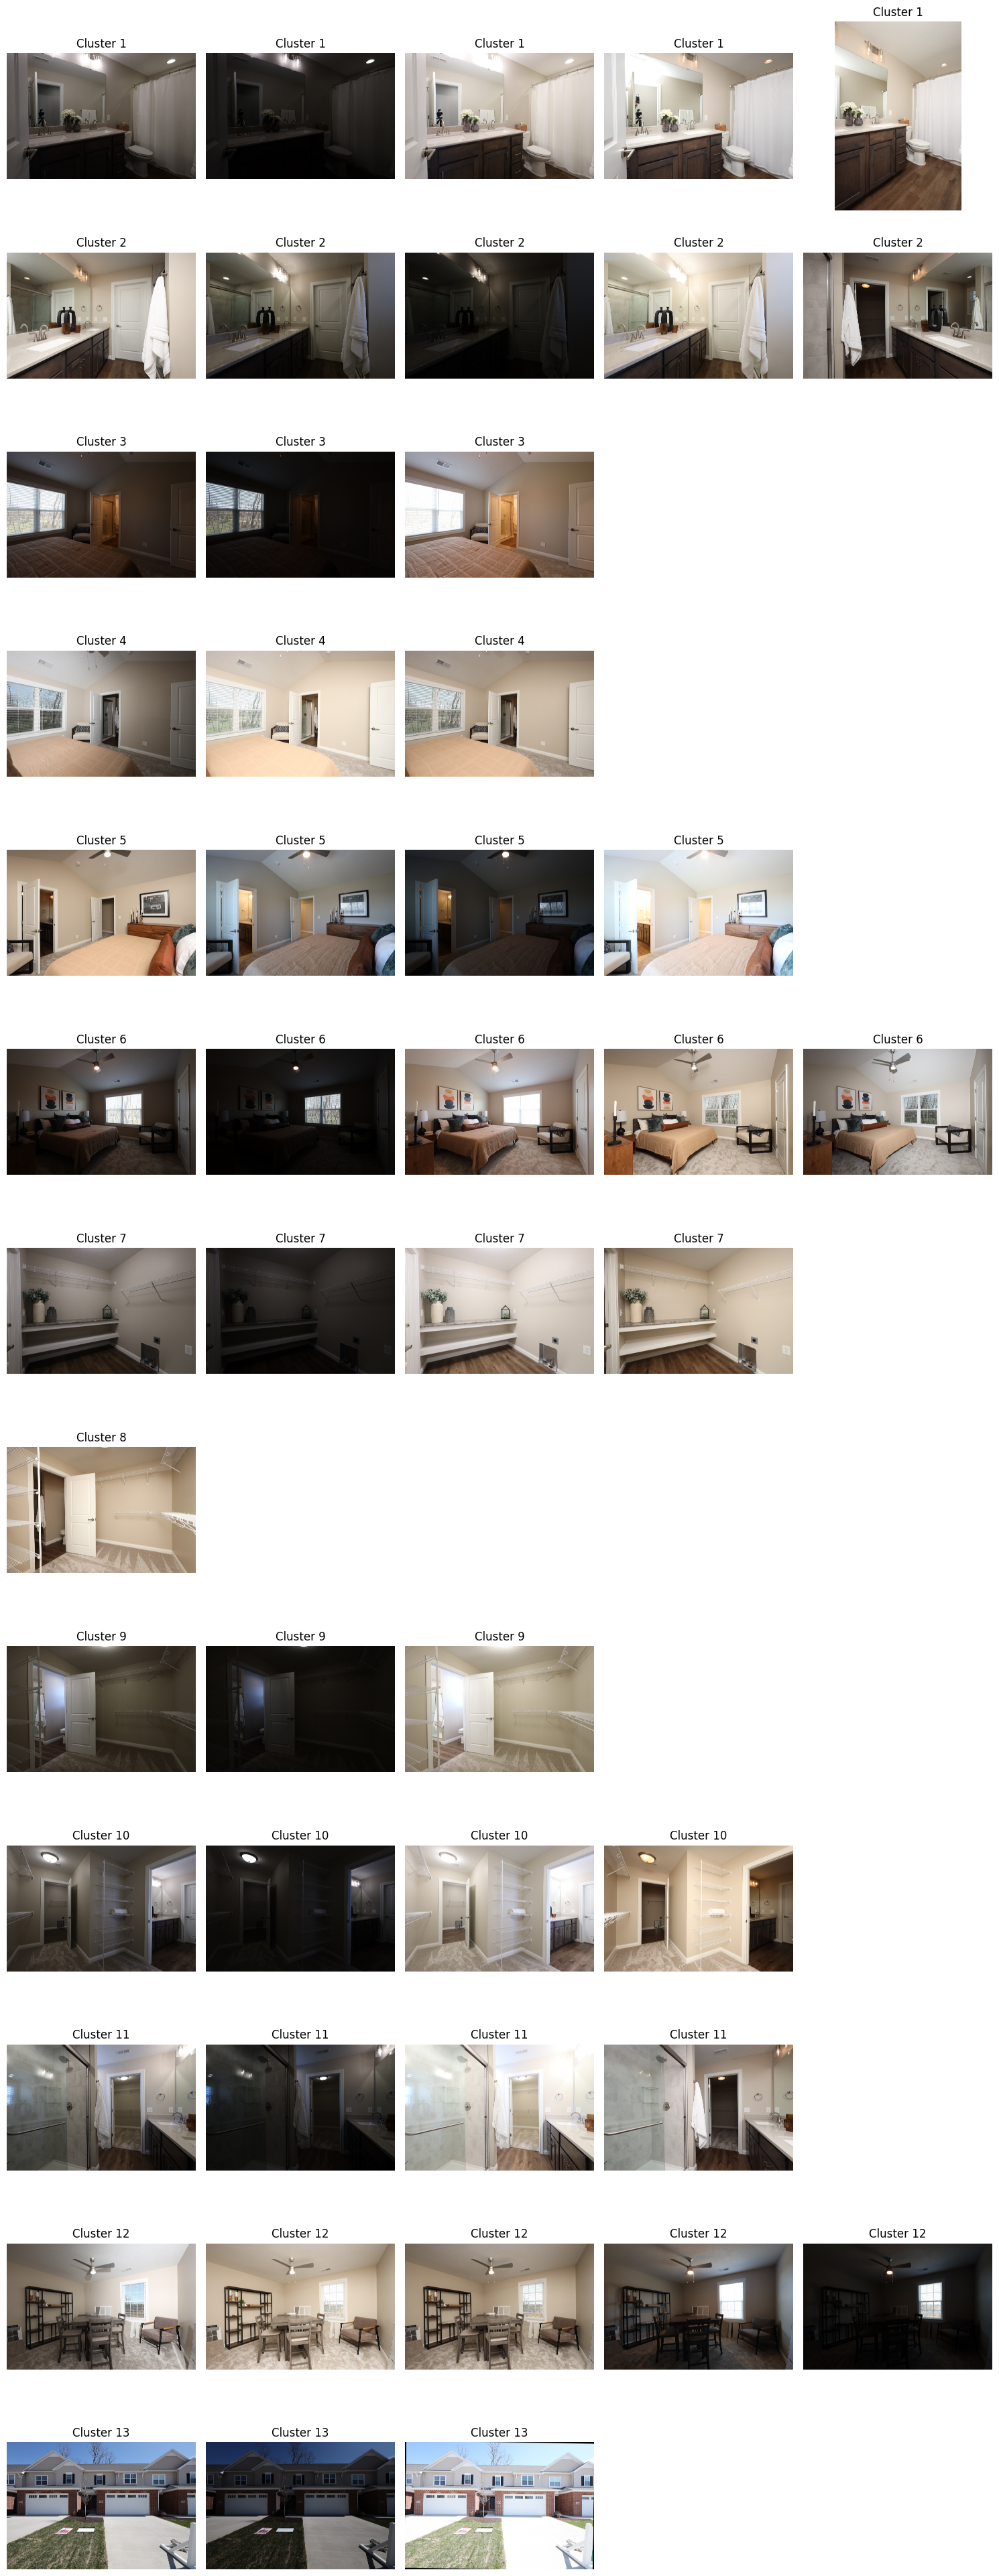

In [118]:
# Run a single baseline configuration
print("\nRunning baseline with minimal parameters...")

# Define minimal parameters
model_name = 'efficientnet_b0'
eps = 12
min_samples = 1
batch_size = 64
use_enhanced_features = False
use_two_stage = True
eps2 = 9

# Use standard transform without enhancements
edge_enhancement = False
perspective_invariant = False
histogram_equalization = True

transform = get_transform(
    use_edge_enhancement=edge_enhancement,
    use_perspective_invariant=perspective_invariant,
    use_histogram_equalization=histogram_equalization
)

# Run the pipeline
clusters, timing, labels, embeddings, paths = run_clustering_pipeline(
    model_name=model_name,
    image_folder=image_folder,
    transform=transform,
    batch_size=batch_size,
    eps=eps,
    min_samples=min_samples,
    use_enhanced_features=use_enhanced_features,
    use_two_stage=use_two_stage,
    eps2=eps2
)

# Print timing information
print("\nTiming Information:")
for key, value in timing.items():
    print(f"  {key}: {value:.4f} seconds")

# Print clustering results
print("\nClustering Results:")
print_cluster_summary(clusters)

# Save results to JSON
output_filename = f"{model_name}_baseline_eps{eps}.json"
results_folder = './model_results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

output_path = os.path.join(results_folder, output_filename)

# Convert paths to relative for better readability
readable_clusters = {}
for cluster_id, image_paths in clusters.items():
    readable_clusters[str(cluster_id)] = [os.path.basename(p) for p in image_paths]

# Include metadata with the clustering results
output_data = {
    "metadata": {
        "model_name": model_name,
        "eps": eps,
        "min_samples": min_samples,
        "use_two_stage": use_two_stage,
        "eps2": eps2,
        "use_edge_enhancement": edge_enhancement,
        "use_perspective_invariant": perspective_invariant,
        "use_histogram_equalization": histogram_equalization,
        "use_enhanced_features": use_enhanced_features,
        "runtime_seconds": timing['total']
    },
    "clusters": readable_clusters
}

with open(output_path, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"\nSaved cluster dictionary to {output_path}")

# Visualize clusters
print("\nCluster Visualization:")
plot_clusters(clusters)

# Further Enhancements/ Next steps

Current model results work well, however in order to make model robust here are a few things we can do
- further normalize images with preprocessing to get an easier comparison
- use a labeled dataset to get better accuracy metrics for model evaluation
- combine labeled dataset with loss function in order to fine tune final layer of CNN embeddings
- hyperparameter search over all possible configurations and pick most robust model

## Setup Hyperparameter Experiments

Here is an example of how we can set up hyperparameter search experiments

We can attempt to fine tune the model by grid search over the hyperparmeters, and pick the best performing model

**WARNING THIS WILL TAKE A LONG TIME TO RUN**

In [88]:
import itertools
from datetime import datetime
import pandas as pd

# Create a model_results folder if it doesn't exist
results_folder = './model_results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    print(f"Created directory: {results_folder}")

# Define hyperparameter search space
search_params = {
    'model_name': ['efficientnet_b0'],  # You can add more models if needed
    'eps': [5.0, 7.5, 10.0],
    'min_samples': [1],  # Usually fixed for your use case
    'use_two_stage': [False, True],
    'eps2': [None, 2.5, 5.0],  # Only used when use_two_stage is True
    'use_edge_enhancement': [False, True],
    'use_perspective_invariant': [False, True],
    'use_histogram_equalization': [False, True],
    'use_enhanced_features': [False, True]
}

# Generate all combinations of hyperparameters
# We'll filter out invalid combinations (e.g., eps2 without two-stage clustering)
all_combinations = list(itertools.product(
    search_params['model_name'],
    search_params['eps'],
    search_params['min_samples'],
    search_params['use_two_stage'],
    search_params['eps2'],
    search_params['use_edge_enhancement'],
    search_params['use_perspective_invariant'],
    search_params['use_histogram_equalization'],
    search_params['use_enhanced_features']
))

# Filter out invalid combinations
valid_combinations = []
for combo in all_combinations:
    model_name, eps, min_samples, use_two_stage, eps2, edge, perspective, histogram, enhanced = combo

    # Skip combinations where eps2 is used but two-stage clustering is not
    if eps2 is not None and not use_two_stage:
        continue

    valid_combinations.append(combo)

print(f"Found {len(valid_combinations)} valid hyperparameter combinations to test")

# Function to create a unique config name
def create_config_name(params):
    model_name, eps, min_samples, use_two_stage, eps2, edge, perspective, histogram, enhanced = params

    config_parts = []

    # Add transform enhancements
    if edge:
        config_parts.append("edge")
    if perspective:
        config_parts.append("persp")
    if histogram:
        config_parts.append("hist")
    if enhanced:
        config_parts.append("enhanced")

    # Add clustering parameters
    config_parts.append(f"eps{eps}")

    if use_two_stage:
        config_parts.append("two_stage")
        if eps2 is not None:
            config_parts.append(f"eps2_{eps2}")

    # Join all parts with underscores
    if config_parts:
        return f"{model_name}_{'_'.join(config_parts)}"
    else:
        return f"{model_name}_standard"

# Create a DataFrame to store results
results_df = pd.DataFrame(columns=[
    'config_name', 'model_name', 'eps', 'min_samples', 'use_two_stage', 'eps2',
    'use_edge', 'use_perspective', 'use_histogram', 'use_enhanced_features',
    'num_clusters', 'total_time', 'cnn_time', 'dbscan_time', 'json_path'
])

# Processing parameters
batch_size = 16  # Batch size for CNN processing

# Start time for the entire process
total_start_time = time.time()

Found 192 valid hyperparameter combinations to test


In [ ]:
# Run through all valid combinations
for i, params in enumerate(valid_combinations):
    model_name, eps, min_samples, use_two_stage, eps2, use_edge, use_perspective, use_histogram, use_enhanced = params

    # Create config name for this run
    config_name = create_config_name(params)

    print(f"\n[{i+1}/{len(valid_combinations)}] Running with configuration: {config_name}")

    # Create the transform for this configuration
    transform = get_transform(
        use_edge_enhancement=use_edge,
        use_perspective_invariant=use_perspective,
        use_histogram_equalization=use_histogram
    )

    try:
        # Run the pipeline
        clusters, timing, labels, embeddings, paths = run_clustering_pipeline(
            model_name=model_name,
            image_folder=image_folder,
            transform=transform,
            batch_size=batch_size,
            eps=eps,
            min_samples=min_samples,
            use_enhanced_features=use_enhanced,
            use_two_stage=use_two_stage,
            eps2=eps2
        )

        # Print summary
        print_cluster_summary(clusters)

        # Create timestamp for unique filenames
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save the cluster dictionary output to a JSON file
        output_filename = f"{config_name}_{timestamp}.json"
        output_path = os.path.join(results_folder, output_filename)

        # Convert paths to relative for better readability
        readable_clusters = {}
        for cluster_id, image_paths in clusters.items():
            readable_clusters[str(cluster_id)] = [os.path.basename(p) for p in image_paths]

        # Include metadata with the clustering results
        output_data = {
            "metadata": {
                "model_name": model_name,
                "eps": eps,
                "min_samples": min_samples,
                "use_two_stage": use_two_stage,
                "eps2": eps2,
                "use_edge_enhancement": use_edge,
                "use_perspective_invariant": use_perspective,
                "use_histogram_equalization": use_histogram,
                "use_enhanced_features": use_enhanced,
                "runtime_seconds": timing['total']
            },
            "clusters": readable_clusters
        }

        with open(output_path, 'w') as f:
            json.dump(output_data, f, indent=2)

        print(f"Saved cluster results to {output_path}")

        # Add results to DataFrame
        results_df = results_df.concat({
            'config_name': config_name,
            'model_name': model_name,
            'eps': eps,
            'min_samples': min_samples,
            'use_two_stage': use_two_stage,
            'eps2': eps2,
            'use_edge': use_edge,
            'use_perspective': use_perspective,
            'use_histogram': use_histogram,
            'use_enhanced_features': use_enhanced,
            'num_clusters': len(clusters),
            'total_time': timing['total'],
            'cnn_time': timing['cnn_feature_extraction'],
            'dbscan_time': timing['dbscan_clustering'],
            'json_path': output_path
        }, ignore_index=True)

    except Exception as e:
        print(f"Error with configuration {config_name}: {str(e)}")
        continue

# Save the results DataFrame
results_csv_path = os.path.join(results_folder, f"hyperparameter_search_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"\nSaved all hyperparameter search results to {results_csv_path}")

# Print total time taken
total_time = time.time() - total_start_time
print(f"Total hyperparameter search time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

# Show the top 5 configurations by number of clusters
print("\nTop 5 configurations by number of clusters:")
display(results_df.sort_values('num_clusters', ascending=False).head(5))

# Show the fastest 5 configurations
print("\nTop 5 fastest configurations:")
display(results_df.sort_values('total_time').head(5))


[1/192] Running with configuration: efficientnet_b0_eps5.0
Using device: cpu
Number of clusters found: 53
  Cluster 1: 1 images
  Cluster 2: 1 images
  Cluster 3: 1 images
  Cluster 4: 1 images
  Cluster 5: 1 images
  Cluster 6: 1 images
  Cluster 7: 3 images
  Cluster 8: 3 images
  Cluster 9: 1 images
  Cluster 10: 1 images
  Cluster 11: 1 images
  Cluster 12: 2 images
  Cluster 13: 1 images
  Cluster 14: 2 images
  Cluster 15: 1 images
  Cluster 16: 2 images
  Cluster 17: 1 images
  Cluster 18: 2 images
  Cluster 19: 1 images
  Cluster 20: 3 images
  Cluster 21: 2 images
  Cluster 22: 1 images
  Cluster 23: 3 images
  Cluster 24: 1 images
  Cluster 25: 1 images
  Cluster 26: 1 images
  Cluster 27: 1 images
  Cluster 28: 1 images
  Cluster 29: 1 images
  Cluster 30: 2 images
  Cluster 31: 1 images
  Cluster 32: 1 images
  Cluster 33: 1 images
  Cluster 34: 1 images
  Cluster 35: 1 images
  Cluster 36: 1 images
  Cluster 37: 1 images
  Cluster 38: 1 images
  Cluster 39: 1 images
  Clu

C:\Users\derek\Documents\Projects\ExposureBracketGrouper\bracket_grouper_model.py:67: RuntimeWarning: invalid value encountered in divide
  hist_features.extend(hist / np.sum(hist))  # Normalize


Error with configuration efficientnet_b0_enhanced_eps5.0: Input X contains NaN.
DBSCAN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

[3/192] Running with configuration: efficientnet_b0_hist_eps5.0
Applied histogram equalization
Using device: cpu
Number of clusters found: 31
  Cluster 1: 2 images
  Cluster 2: 1 images
  Cluster 3: 2 images
  Cluster 4: 1 images
  Cluster 5: 3 images
  Cluster 6: 3 images
  Cluster 7: 3 images
  Cluster 8: 3 i